<a href="https://colab.research.google.com/github/sunRise9551/Building_Makemore/blob/main/Makemore_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Review

## Libraries

In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Datasets

In [53]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-09-28 04:22:56--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-09-28 04:22:56 (5.62 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [54]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [55]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [56]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [57]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
# block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [58]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


## Neural Network Architecture

In [8]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flattern:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


## Initialize Parameters

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


## Optimization

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] #embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2754
  10000/ 200000: 2.6138
  20000/ 200000: 2.1628
  30000/ 200000: 2.1965
  40000/ 200000: 2.1152
  50000/ 200000: 2.2669
  60000/ 200000: 2.5031
  70000/ 200000: 2.1370
  80000/ 200000: 1.7184
  90000/ 200000: 2.4792
 100000/ 200000: 1.9066
 110000/ 200000: 2.3437
 120000/ 200000: 2.4118
 130000/ 200000: 2.3965
 140000/ 200000: 2.6474
 150000/ 200000: 2.3924
 160000/ 200000: 2.2070
 170000/ 200000: 1.8034
 180000/ 200000: 2.3456
 190000/ 200000: 2.0389


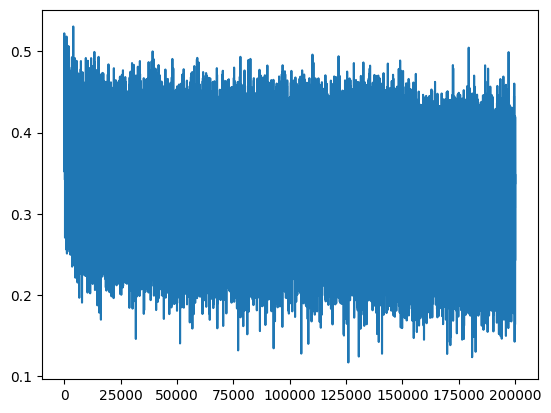

In [11]:
plt.plot(lossi)

## Evaluation

In [12]:
# put layers into eval mode(needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [13]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size, n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0606484413146973
val 2.1084649562835693


## Sampling

In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

# Fix Learning rate plot

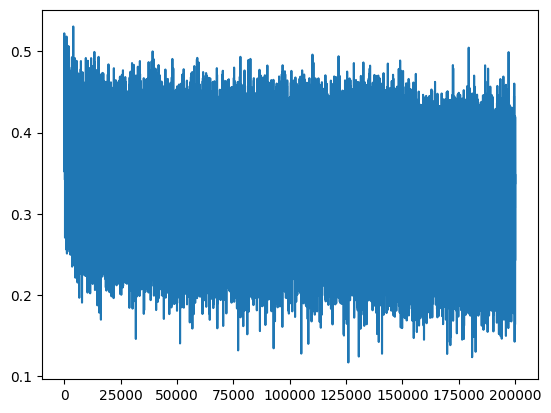

In [14]:
plt.plot(lossi)

In [15]:
lossi[:10] # is a python list of floats

[0.5152618288993835,
 0.5091684460639954,
 0.5045637488365173,
 0.5222075581550598,
 0.48243483901023865,
 0.5043321251869202,
 0.5118957757949829,
 0.4975320100784302,
 0.4940631687641144,
 0.4738340675830841]

## Random example

In [16]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
torch.arange(10).view(2,5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [18]:
torch.arange(10).view(5, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [19]:
torch.arange(10).view(5, -1)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [20]:
torch.arange(10).view(-1, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

## The Fix

In [21]:
torch.tensor(lossi).view(-1, 1000).shape # We stretch -1, means whatever it is, into rows of 1000 consecutive element

torch.Size([200, 1000])

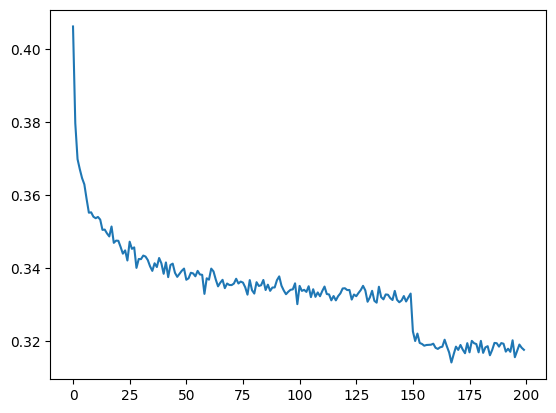

In [22]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # We take the mean of every rows

# Fix Layers

We will create Layers for Embedding and Flattern

In [ ]:
# --------------------------------------------------------------------
emb = C[x] # (N, block_size, n_embd)
x = emb.view(emb.shape[0], -1) # concat into (N, block_size, n_embd)
# --------------------------------------------------------------------
for layer in layers:
  x = layer(x)

Recall that while we are creating Layer

In [ ]:
# --------------------------------------------------------------------
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
# --------------------------------------------------------------------
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

In [24]:
# Added Embedding and Flatten Later

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# Embedding Layer
# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim)) # <--- Initiating 'C' with given num_embeddings, and embedding_dim

  def __call__(self, IX):
    self.out = self.weight[IX] # <--- Indexing operation
    return self.out

  def parameters(self):
    return [self.weight]

# Flatten Layer
# -----------------------------------------------------------------------------------------------
class Flattern:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1) # <--- Flatterning operation
    return self.out

  def parameters(self):
    return []



## Changes in Initialization

In [25]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

layers = [
    Embedding(vocab_size, n_embd),
    Flattern(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()] # <--- Taken out 'C'
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


## Changes in Optimization

In [26]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  # emb = C[Xb] #embed the characters into vectors <----------------- Removed
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors <------- Removed
  x = Xb # <--------------------------------------------------------- Added
  # The tensor of integers specifying the identities of these characters at the input

  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break


      0/ 200000: 3.3025


Run wells!

# Containers

## Add Sequential Class

In [51]:
# Added Embedding and Flatten Later

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim)) # <--- Initiating 'C' with given num_embeddings, and embedding_dim

  def __call__(self, IX):
    self.out = self.weight[IX] # <--- Indexing operation
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flattern:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1) # <--- Flatterning operation
    return self.out

  def parameters(self):
    return []

# Sequential
# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

## Simplified Initialize

In [45]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flattern(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# parameters = [p for layer in layers for p in layer.parameters()] # <--- Removed
parameters = model.parameters() # <--------------------------------------- Added
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


## Simplfied Optimization

In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  # --------------------------------------------- Removed
  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  # --------------------------------------------- Removed

  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function # <---- 'x' changes to 'logits'

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break


      0/ 200000: 3.2003


Run wells!

## Simplified Evaluation

In [47]:
# put layers into eval mode(needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [48]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  logits = model(x) # <--------------
  loss = F.cross_entropy(logits, y) # <--------------
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 3.4995670318603516
val 3.5026721954345703


## Simplified Sampling

In [49]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net

      # -----------------------------------------------------------
      # emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      # x = emb.view(emb.shape[0], -1) # concatenate the vectors
      # for layer in layers:
      #   x = layer(x)
      # logits = x
      # -----------------------------------------------------------

      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

lehpbypemnueyszcprmqt.
dttmbx.
lg.
wzuuvvmpeypk.
smwitwceapaw.
jeforgckgmethbkeoetquzcwqurgcuqjzrmkcfierqjqrqccca.
mkvap.
xjdibfdxfpycunzpzijkkmvhogxwqbwivnwtyliygdyefvmgzc.
ldqzpnillpuocxxljgxfvejch.
gvcorbfeurhldqaanreskwgkbjnlreijhsettfltsbpfrbja.
fwlnkgxfcrnodpzmlzwzdvbsnbafhyoxyyatawzjgqnpuzqnoi.
lwakptjqjzspgvshlgfypqdirxysiycrzqrjqubukykdtryinon.
msxmeqrhkhtwvspxdyqwojmdailga.
tqnvzgkoqeyo.
gmcqnahpxdrkiceyxtrpywioyak.
gtltrgnwfyqub.
zqjujxwb.
onbkiilevtrswrwtnbgkbeikvpecjdwjljfjzmaceyrcvcgwz.
cvdfokalzfmlurfrxmdnnngzkgxtfvpthxpylemavbwpehyjpreqmiepedruvxsjnxoyizpcxtppcvmccjarebfdyt.
j.


# Implementing WaveNet

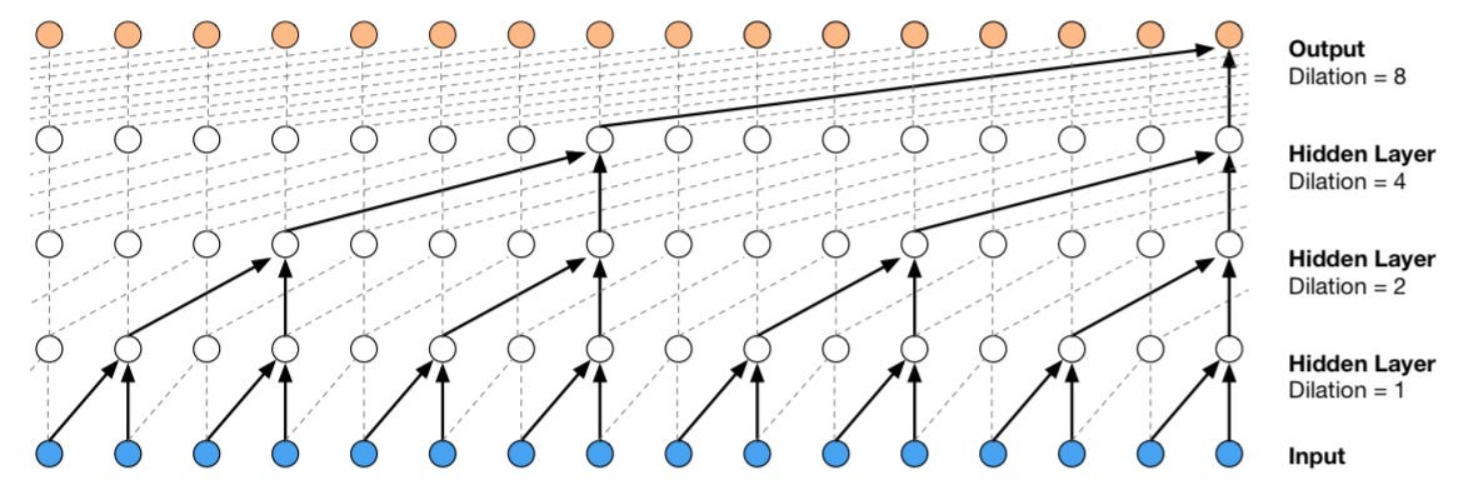

Performance log

- Original

In [50]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 3])


tensor([[ 0,  0, 20],
        [ 0,  0,  0],
        [15,  8,  5],
        [ 0,  0,  0]])

In [59]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([4, 3, 10])

In [60]:
model.layers[1].out.shape # output of Flattern layer

torch.Size([4, 30])

In [62]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [63]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [64]:
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 2, 200])

In [ ]:
list(range(10))[::2]

In [ ]:
list(range(10))[1::2]

In [ ]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated

In [ ]:
e.[:,::2,:]

In [ ]:
e.[:,1::2,:]

In [ ]:
explicit = torch.cat([e.[:,::2,:], e.[:,1::2,:]], dim=2).shape

In [ ]:
e.view(4, 4, 20) == explicit.all()

## Changes in Network Architecture

Change Flattern Layer

In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlatternConsecutive: # <----- We call this FlatternConsecutive, depart from PyTorch's Flattern()
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


Explaination

    class FlatternConsecutive: # <----- We call this FlatternConsecutive, depart from PyTorch's Flattern()
      def __init__(self, n):
        self.n = n

      def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
          self.out = x.squeeze(1)
        return self.out

      def parameters(self):
        return []

B, T, C

    B, T, C = x.shape


  - takes Batch, Time-stamps, Channels
  - corresponds to (4, 8, 10) <-- The inputs passed into Flattern

We want to change (4, 8, 10) into (4, 4, 20), so:

    self.out = x.view(B, T//self.n, C*self.n)

  - B is Batch, it remains
  - T//self.n is Round integer divide, we can also use -1
  - C*self.n is given Channels multiply with number of consecutive we want (10 x 2)=20

Edge cases

    if x.shape[1] == 1:
          self.out = x.squeeze(1)

- if T is 1, we want to return 2 dimension
- so we squeeze out the 2nd index dimension

## Changes in Initialization

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

layers = [
    Embedding(vocab_size, n_embd),
    FlatternConsecutive(block_size), # <------ Changes
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()] # <--- Taken out 'C'
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# forward pass
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':' tuple(layer.out.shape))

## Implement WaveNet

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# -----------------------------------------------------------------------------------------------------
layers = [
    Embedding(vocab_size, n_embd),
    FlatternConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlatternConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlatternConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]
# -----------------------------------------------------------------------------------------------------

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()] # <--- Taken out 'C'
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# forward pass
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':' tuple(layer.out.shape))

# Fixing BatchNorm1d Bug

Changes number of hiddens to 68

In [ ]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - mean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

.mean() can take in tuple

In [ ]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True) # 1, 1, 68
evar = e.var((0, 1), keepdim=True) # 1, 1, 68
ehat = (e - mean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

In [ ]:
emean.shape

## Changes in Network Architecture

In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlatternConsecutive: # <----- We call this FlatternConsecutive, depart from PyTorch's Flattern()
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


Evaluate and Sample, All Done :)